In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('dataset.csv')
print(f"Shape dataset: {df.shape}")
print(f"Dataset columns: {df.columns}")
print(df.head())

Shape dataset: (58, 8)
Dataset columns: Index(['date', 'index', 'avg price', 'sales vol', 'cpi', 'crime count', 'VIX',
       'bba mortgage rate'],
      dtype='object')
         date       index    avg price  sales vol  cpi  crime count    VIX  \
0  01/01/2020  118.145931  475947.8309       6527  1.8        91686  13.94   
1  01/02/2020  117.781651  474480.3413       6465  1.7        87403  19.63   
2  01/03/2020  119.798382  482604.6877       6842  1.5        82576  57.74   
3  01/04/2020  118.198439  476159.3587       3206  0.9        65938  41.45   
4  01/05/2020  117.470114  473225.3197       2929  0.7        75746  30.90   

   bba mortgage rate  
0               4.27  
1               4.26  
2               4.10  
3               3.66  
4               3.65  


In [3]:
features = ["sales vol", "cpi", "crime count", "VIX", "bba mortgage rate"]
target = "index"

In [4]:
cols = 2
rows = (len(features) + 1) // cols

## Visualisation of the features values w.r.t. to the corresponding Index values

#### Analysis:
For the "cpi" feature, we observe a clear linear relationship with the target variable "index". The regression line has a visible positive slope, with limited dispersion around it, suggesting that "cpi" may have predictive power.

For the "crime count" and "sales vol" features, no significant relationship is visually apparent with the target variable. The regression lines are nearly flat, showing no clear linearity, and the points are highly dispersed. However, their potential in interaction with other features or in non-linear models remains to be explored.

Finally, the "VIX" feature demonstrates a decreasing regression line. However, the relationship appears weak, with high dispersion and possible non-linearity. This could be influenced by outliers, which may require further analysis (e.g., through boxplots or statistical methods).

Based on this visual representation, "cpi" seems to have the strongest predictive potential for "index", while the other three features show limited direct predictive power in a linear regression context.

For the "bba mortgage rate" feature, the scatter plot reveals distinct patterns. A substantial number of points are concentrated around mortgage rates of approximately 3.7 and 8. At a rate of around 3.7, the associated index values are highly dispersed, spanning a wide range between 115 and 128. This indicates significant variability in the index values for this cluster, suggesting that other factors may influence the relationship at lower mortgage rates.
Conversely, at a rate of approximately 8, the index values are much less dispersed, ranging narrowly between 125 and 132. This reduced variability suggests a more consistent relationship between higher mortgage rates and the index, potentially indicating that at elevated mortgage rates, the housing market dynamics become less volatile.
Between these two clusters (rates of 3.7 and 8), a smaller number of points are observed. These points exhibit elevated index values and form a concave parabolic shape, suggesting a non-linear relationship in this range. This could imply that as mortgage rates increase from 3.7 to intermediate values, the index initially rises before stabilizing or decreasing again at higher rates.
These observations highlight a complex and non-linear relationship between the "bba mortgage rate" and "index", with distinct behaviors at low and high mortgage rates. The variability at lower rates could reflect the influence of affordability or demand fluctuations, while the consistency at higher rates may suggest more stable market conditions. However, further investigation and statistical testing are necessary to validate these patterns and assess their relevance in the predictive model.

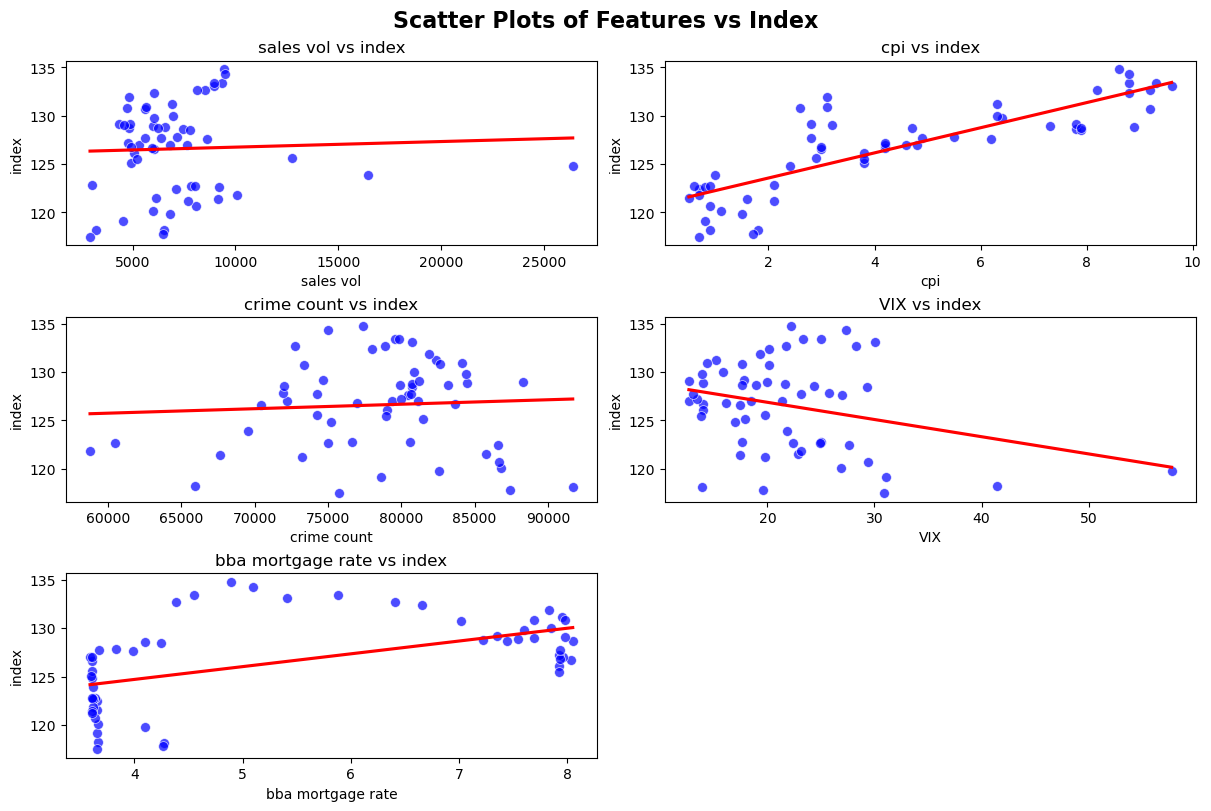

In [5]:
fig, axes = plt.subplots(rows, cols, figsize=(12, 8), constrained_layout=True)

for i, feature in enumerate(features):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    
    sns.scatterplot(data=df, x=feature, y=target, ax=ax, color='blue', alpha=0.7, s=50)
    sns.regplot(data=df, x=feature, y=target, scatter=False, ax=ax, color='red', ci=None)
    
    ax.set_title(f"{feature} vs {target}", fontsize=12)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel(target, fontsize=10)

for j in range(len(features), rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.suptitle("Scatter Plots of Features vs Index", fontsize=16, weight='bold')
plt.show()

## Simple linear regressions for each pair of feature/target

### Analysis:
For the feature "sales vol", the regression shows a very small negative coefficient (-0.000009) with an almost flat regression line, as confirmed by the near-zero R2 values for both the train set (0.000062) and the test set (-0.092993). The t-value is extremely low (-0.052280), and the pp-value (0.9585425) is far from the significance threshold of 0.05, indicating that this feature has no significant linear relationship with the target variable "index".

For the feature "cpi", the results suggest a strong positive linear relationship with "index". The coefficient is substantial (1.234742), indicating that an increase in CPI by 1 unit is associated with an increase of approximately 1.23 in the "index". The R2 values are high for both the train set (0.660471) and the test set (0.748406), suggesting good predictive power and generalization. Additionally, the t-value is large (9.251554), and the pp-value is extremely small (6.956362e-12), confirming the statistical significance of this feature.

For the feature "crime count", the regression results do not show a significant relationship with "index". The coefficient is very small (-0.000053), and the R2 values are close to zero for the train set (0.003575) and negative for the test set (-0.163974). The t-value is low (-0.397327), and the pp-value (0.6930474) indicates no statistical significance. This suggests that "crime count" does not have predictive power for the target variable in a linear regression context.

For the feature "bba mortgage rate", the regression results show a moderate positive relationship with "index". The coefficient (1.217570) suggests that an increase in "bba mortgage rate" by 1 unit is associated with an increase of approximately 1.22 in the "index". The train set R2R2 (0.261914) and test set R2R2 (0.294175) indicate that this feature explains some variance in the target variable, though not as much as "cpi". The t-value (3.951410) is relatively high, and the p-value (0.00027765) is well below the 0.05 threshold, confirming the statistical significance of this feature in the linear regression context. However, the moderate R2R2 values suggest that the relationship may not be entirely linear, and further exploration (e.g., interaction terms or transformations) could reveal additional insights.

In [6]:
model = LinearRegression()
results = []

for feature in features:
    X = df[[feature]]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train).fit()
    y_test_pred = model.predict(X_test)

    r2_train = model.rsquared
    r2_test = r2_score(y_test, y_test_pred)
    coef = model.params[feature]
    intercept = model.params['const']
    p_value = model.pvalues[feature]
    t_value = model.tvalues[feature]

    results.append({
        "Feature": feature,
        "Coefficient": coef,
        "Intercept": intercept,
        "t-value": t_value,
        "p-value": p_value,
        "R² (Train)": r2_train,
        "R² (Test)": r2_test
    })

In [7]:
results_df = pd.DataFrame(results)
results_df

,Feature,Coefficient,Intercept,t-value,p-value,R² (Train),R² (Test)
0,sales vol,-0.000009,126.973771,-0.052280,9.585425e-01,0.000062,-0.092993
1,cpi,1.234742,121.415255,9.251554,6.956362e-12,0.660471,0.748406
2,crime count,-0.000053,131.093607,-0.397327,6.930474e-01,0.003575,-0.163974
3,VIX,-0.144351,130.011023,-1.635978,1.089786e-01,0.057340,0.070545
4,bba mortgage rate,1.217570,120.358461,3.951410,2.776529e-04,0.261914,0.294175


### Multiple linear regression

### Analysis:

Overall Model Performance:

    R-squared (R²): 0.751
    The model explains 75.1% of the variance in the target variable "index", indicating that the predictors collectively provide a strong explanation of the variance in the dependent variable.

    Adjusted R-squared: 0.720
    This adjusted value accounts for the number of predictors in the model. The relatively small difference between R2 and R2-adjusted​ suggests that most predictors contribute meaningfully to the model.

    F-statistic: 24.12 (p-value = 4.13e-11)
    The overall model is statistically significant, confirming that the predictors are jointly associated with the target variable "index".

Analysis of Individual Predictors:

    Constant (const):
        Coefficient: 120.0411
        This represents the predicted value of "index" when all predictors are zero.
        Significance: The p-value is <0.0001, indicating that the intercept is statistically significant.

    sales vol:
        Coefficient: 0.0001
        A one-unit increase in sales vol leads to a negligible predicted increase of 0.0001 in "index".
        Significance: p=0.166, not statistically significant.
        This suggests that sales vol does not contribute meaningfully to predicting "index" in this model.

    cpi:
        Coefficient: 1.0802
        A one-unit increase in cpi is associated with an increase of 1.0802 in "index", highlighting a strong positive relationship.
        Significance: p<0.0001, highly statistically significant.
        This confirms that cpi is one of the most important predictors in the model.

    crime count:
        Coefficient: −2.607×10−5
        A one-unit increase in crime count leads to a negligible predicted decrease of −2.607×10−5 in "index".
        Significance: p=0.750, not statistically significant.
        This suggests that crime count does not meaningfully contribute to the model.

    VIX:
        Coefficient: −0.0408
        A one-unit increase in VIX is associated with a slight decrease of 0.0408 in "index".
        Significance: p=0.483, not statistically significant.
        This indicates that VIX does not have a meaningful impact on the target variable in this model.

    bba mortgage rate:
        Coefficient: 0.7260
        A one-unit increase in bba mortgage rate is associated with an increase of 0.7260 in "index", indicating a positive relationship.
        Significance: p=0.010, statistically significant at the 0.050.05 level.
        This suggests that bba mortgage rate contributes meaningfully to the model, though its impact is less pronounced than cpi.

Model Diagnostics:

    Durbin-Watson Statistic: 2.018
    This value is close to 2, suggesting that the residuals are independent and there is no evidence of significant autocorrelation.

    Residual Normality (Omnibus and Jarque-Bera Tests):
        The Omnibus test (p=0.949) and Jarque-Bera test (p=0.236) suggest that the residuals do not deviate significantly from normality.

    Condition Number: 1.45e+06
    This high value indicates potential multicollinearity between the predictors. Further analysis using the Variance Inflation Factor (VIF) is recommended to confirm this.

In [22]:
X = df[["sales vol", "cpi", "crime count", "VIX", "bba mortgage rate"]]
y = df["index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_multiple = sm.OLS(y_train, X_train).fit()

print(model_multiple.summary())

                            OLS Regression Results                            
Dep. Variable:                  index   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     24.12
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           4.13e-11
Time:                        16:09:00   Log-Likelihood:                -101.61
No. Observations:                  46   AIC:                             215.2
Df Residuals:                      40   BIC:                             226.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               120.0411      6.32

#### Analysis
The R² of the test set is higher than the one of the train test!

In [10]:
y_test_pred = model_multiple.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
print(f"R² on Test Set: {r2_test:.4f}")

R² on Test Set: 0.8440


#### Residual vs Fitted Values

#### Analysis
1. Presence of Non-Linearity
- Observation:
The LOWESS line (red) shows a noticeable curve, particularly between fitted values of approximately 124 and 127, forming a "wave-like" or non-linear pattern.
This indicates that the residuals are not randomly distributed around zero, which violates the assumption of linearity.

- Implication:
This pattern suggests that the model does not fully capture some non-linear relationships in the data.
It may indicate the need for a non-linear transformation of one or more predictors or the response variable to better capture the relationship.

2. Heteroskedasticity (Non-Constant Variance)
- Observation:
The spread of residuals seems fairly consistent for most of the fitted values but widens slightly at higher fitted values (around 130+).
This could suggest mild signs of heteroskedasticity, where the variance of residuals increases with the predicted values.

- Implication:
This slight "funnel-like" shape at higher fitted values could indicate that the variance is not constant, violating the assumption of homoskedasticity.
While this effect is not extreme, it may benefit from further investigation.

3. Outliers
- Observation:
There are a few points with residuals significantly above or below zero (e.g., around 6 and -6).
These could be potential outliers that have a disproportionate influence on the model.

- Implication:
Outliers should be examined more closely. They could indicate data entry errors, unusual observations, or model misfit. Removing or transforming these points might improve the model.

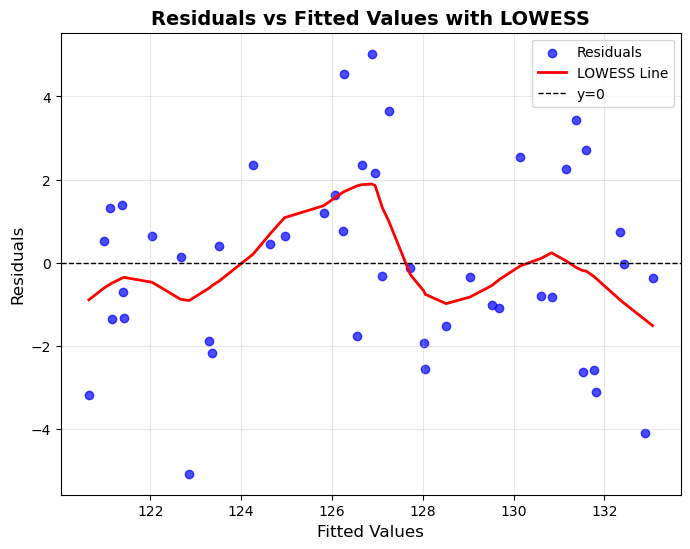

In [11]:
fitted_values = model_multiple.fittedvalues
residuals = model_multiple.resid
lowess_fit = lowess(residuals, fitted_values, frac=0.3)
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.7, color='blue', label='Residuals')
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='red', linewidth=2, label='LOWESS Line')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='y=0')
plt.title("Residuals vs Fitted Values with LOWESS", fontsize=14, weight='bold')
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Residual vs time plot

#### Analysis;
- No Strong Seasonal Pattern:
The residuals do not show a clear, repetitive seasonal pattern. While there are periods of fluctuation, these appear irregular rather than cyclical.

- Possible Short-Term Correlation:
At certain intervals, adjacent residuals appear to cluster above or below the red y=0 line, suggesting mild short-term correlation. For example, there are stretches where residuals are consistently positive or negative (e.g., from 01/03/2023 to 01/07/2023).

- Stable Variance:
The spread of residuals seems fairly consistent over time, with no visible increase or decrease in their variability.

The Durbin-Watson statistic is approximately 2.0, indicating no significant autocorrelation in the residuals. This numerical result aligns with the visual analysis of the plot:
While there may be minor localized clustering of residuals, the absence of strong patterns or trends over time suggests that autocorrelation is not a concern in this model.

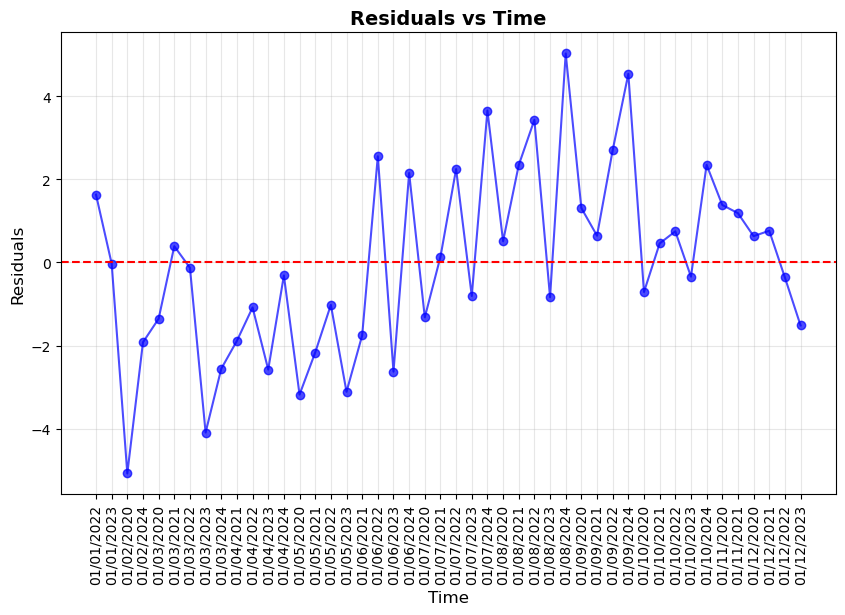

In [12]:
residuals_with_dates = df.loc[model_multiple.resid.index, ["date"]]
residuals_with_dates["residuals"] = model_multiple.resid.values
residuals_with_dates = residuals_with_dates.sort_values(by="date", ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(residuals_with_dates["date"], residuals_with_dates["residuals"], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Time", fontsize=14, weight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.xticks(rotation=90)
plt.grid(alpha=0.3)
plt.show()

#### Normal Q-Q Plot

#### Analysis:
1. Alignment with the Line
The majority of the points lie close to the red reference line, especially in the center of the distribution.
This indicates that the residuals approximately follow a normal distribution in the middle range.

2. Deviations in the Tails
At the extreme ends (both lower and upper quantiles), there are slight deviations from the line.

3. Overall Normality
Despite the slight deviations in the tails, the Q-Q plot indicates that the residuals are reasonably close to normal.
The deviations in the tails are not extreme, so the assumption of normality is mostly satisfied, especially for the purpose of regression analysis.

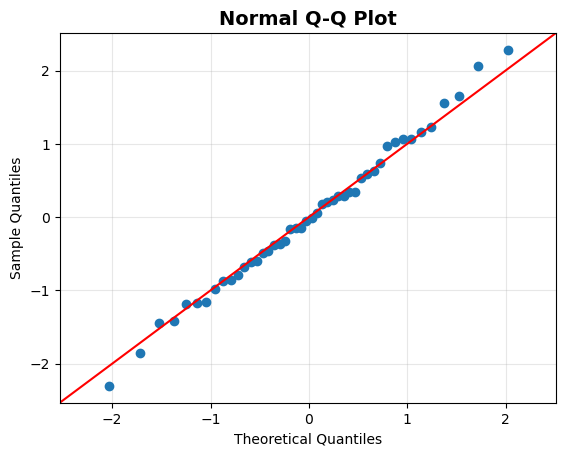

In [13]:
sm.qqplot(residuals, line='45', fit=True)
plt.title("Normal Q-Q Plot", fontsize=14, weight='bold')
plt.grid(alpha=0.3)
plt.show()

#### Scale Location Plot

#### Analysis:
1. Spread of Residuals
- Observation:
The red LOWESS line (trend line) does not remain perfectly flat across the range of fitted values. There are visible fluctuations, particularly around the middle and higher fitted values.
The spread of residuals is fairly consistent for lower fitted values but becomes more variable toward the middle and higher ranges (around fitted values of 126–132).

- Implication:
The fluctuations suggest mild heteroskedasticity, as the variance of the residuals is not perfectly constant across the fitted values.
While not extreme, this pattern indicates a potential violation of the assumption of homoskedasticity.

2. Discernible Patterns
- Observation:
No clear "funnel shape" (narrowing or widening) is evident in the plot. However, the trend line does show peaks and valleys, indicating that the residual variance might change slightly depending on the fitted values.

- Implication:
The lack of a clear funnel shape is a good sign, but the variability observed could still warrant further exploration or correction.

3. Standardized Residuals
- Observation:
The standardized residuals are mostly centered around the horizontal axis, with values within a reasonable range (no extreme outliers).
However, a few points deviate more than others, particularly in regions of higher fitted values.

- Implication:
These points could indicate areas where the model struggles to fit the data properly, potentially suggesting non-linearity or interactions not captured by the model.

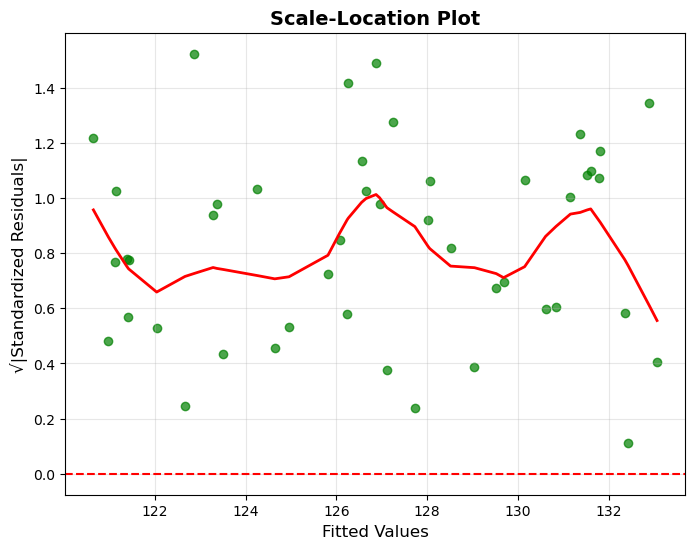

In [14]:
standardized_residuals = model_multiple.get_influence().resid_studentized_internal
abs_sqrt_residuals = np.sqrt(np.abs(standardized_residuals))
lowess_fit = lowess(abs_sqrt_residuals, fitted_values, frac=0.3)

plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, abs_sqrt_residuals, alpha=0.7, color='green')
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='red', linewidth=2, label='LOWESS Line')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Scale-Location Plot", fontsize=14, weight='bold')
plt.xlabel("Fitted Values", fontsize=12)
plt.ylabel("√|Standardized Residuals|", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


#### Residuals vs Leverage Plot

#### Analysis:
1. High Leverage Points
- Definition: High leverage points are those with a high value of the "Leverage" metric (y-axis), indicating that they have an unusual combination of predictor values.
- In this plot:
Observations 2 and 17 have the highest leverage, standing out significantly compared to other points.

2. High Residual Points
- Definition: Points with large residuals (high values on the x-axis, "Normalized residuals²") have predicted values that deviate considerably from the actual values.
- In this plot:
Observations 1, 55, and 56 have the largest residuals and are positioned far to the right.
These points warrant further investigation as they could represent outliers or errors.

3. Cook’s Distance
- Definition: Cook’s distance identifies points that have a significant influence on the regression line. These points are often marked with curved contours on such plots (if included).
- In this plot:
While no Cook’s distance thresholds are explicitly drawn, points with a combination of high leverage and large residuals (e.g., 1, 55, 56, 17 and 2) are likely influential observations.

Implications:
- Influential Points:
Observations 1, 55, 56, 17 and 2 may significantly impact the regression results.
Removing or modifying these points could result in notable changes to the regression coefficients and other model metrics.

- Outliers vs Influential Points:
Points with high leverage or large residuals are not necessarily outliers. They need further investigation based on domain knowledge and data context.
For example, if these points are genuine observations and not data errors, their influence should be retained. If they represent data collection errors, they should be excluded.

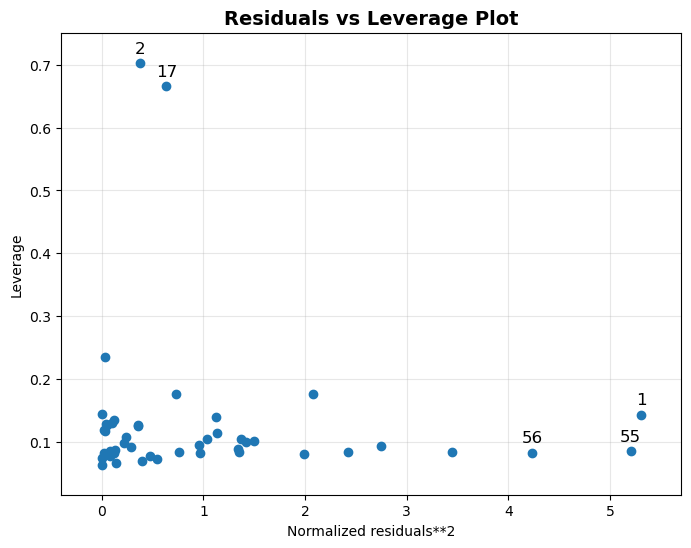

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_leverage_resid2(model_multiple, ax=ax)
plt.title("Residuals vs Leverage Plot", fontsize=14, weight='bold')
plt.grid(alpha=0.3)
plt.show()

### Multicollinearity among features

#### Analysis:
Non-linear relationship between "cpi" and "bba mortgage rate"

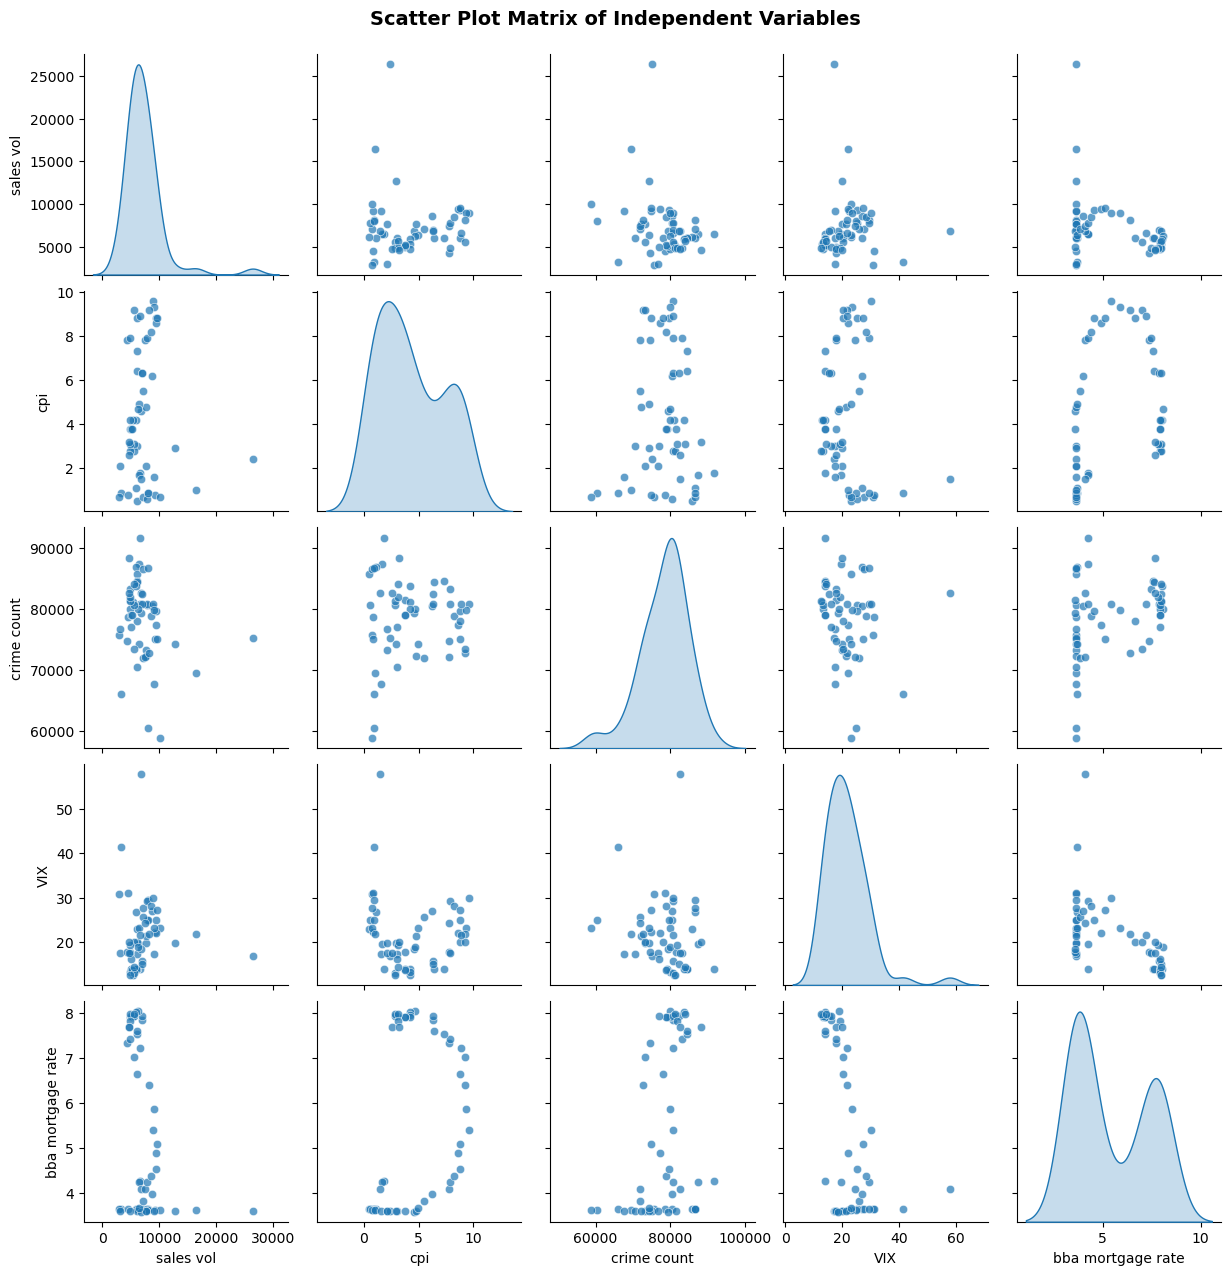

In [16]:
sns.pairplot(df[features], diag_kind='kde', plot_kws={'alpha': 0.7})
plt.suptitle("Scatter Plot Matrix of Independent Variables", y=1.02, fontsize=14, weight='bold')
plt.show()

## Tackle the Potential Multicolinearity Between "cpi" and "bba mortgage rate"

The VIF are small for "cpi" and "bba mortgage rate", no multicolinearity issue

In [23]:
X = df[["cpi", "bba mortgage rate"]]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Variable       VIF
0              const  9.580756
1                cpi  1.155225
2  bba mortgage rate  1.155225


## Global Analysis of the Multiple Regression

The analysis of the multiple regression model revealed several important observations regarding its performance and potential issues. First, multicollinearity does not appear to be a significant concern.

When evaluating the performance of individual variables, it becomes evident that only the cpi and bba mortgage rate variables are statistically significant, with a low p-value and a strong contribution to the prediction of the target variable, index. In contrast, the other predictors, including sales vol, crime count, and VIX, are not significant and add little explanatory value to the model. This suggests that a simplified model focusing on cpi an dbba mortgage rate may be more appropriate.

The diagnostic plots reveal additional insights. The residuals are approximately normally distributed, as confirmed by the Q-Q plot, and there are no strong indications of autocorrelation based on the Residuals vs Time plot and the Durbin-Watson statistic (2.018). However, the Scale-Location plot indicates mild heteroskedasticity, with some variability in the spread of residuals across fitted values. Additionally, the Residuals vs Leverage plot identifies a few influential data points with high leverage or large residuals, which could disproportionately affect the regression results.

Overall, while the model performs well in capturing the relationship between cpi, bba mortgage rate and index, the other predictors appear unnecessary, and there are indications of mild heteroskedasticity and influential points that warrant further investigation. These findings suggest that simplifying the model could enhance its robustness and predictive accuracy.

In [98]:
X = df[["cpi", "bba mortgage rate"]]
y = df["index log"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_simple_cpi = sm.OLS(y_train, X_train).fit()

print(model_simple_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:              index log   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     57.46
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           7.14e-13
Time:                        16:50:11   Log-Likelihood:                 118.87
No. Observations:                  46   AIC:                            -231.7
Df Residuals:                      43   BIC:                            -226.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.7758      0.00

In [99]:
y_test_pred = model_simple_cpi.predict(X_test)
y_train_pred = model_simple_cpi.predict(X_train)

r2_test = r2_score(y_test, y_test_pred)
print(f"R² on Test Set: {r2_test:.4f}")

R² on Test Set: 0.7943


In [100]:
train_data = pd.DataFrame({
    "Date": df.loc[y_train.index, "date"],
    "Actual": y_train.sort_index(),
    "Predicted": y_train_pred,
    "Dataset": "Train"
})

test_data = pd.DataFrame({
    "Date": df.loc[y_test.index, "date"],
    "Actual": y_test.sort_index(),
    "Predicted": y_test_pred,
    "Dataset": "Test"
})

combined_data = pd.concat([train_data, test_data])
combined_data = combined_data.sort_index()

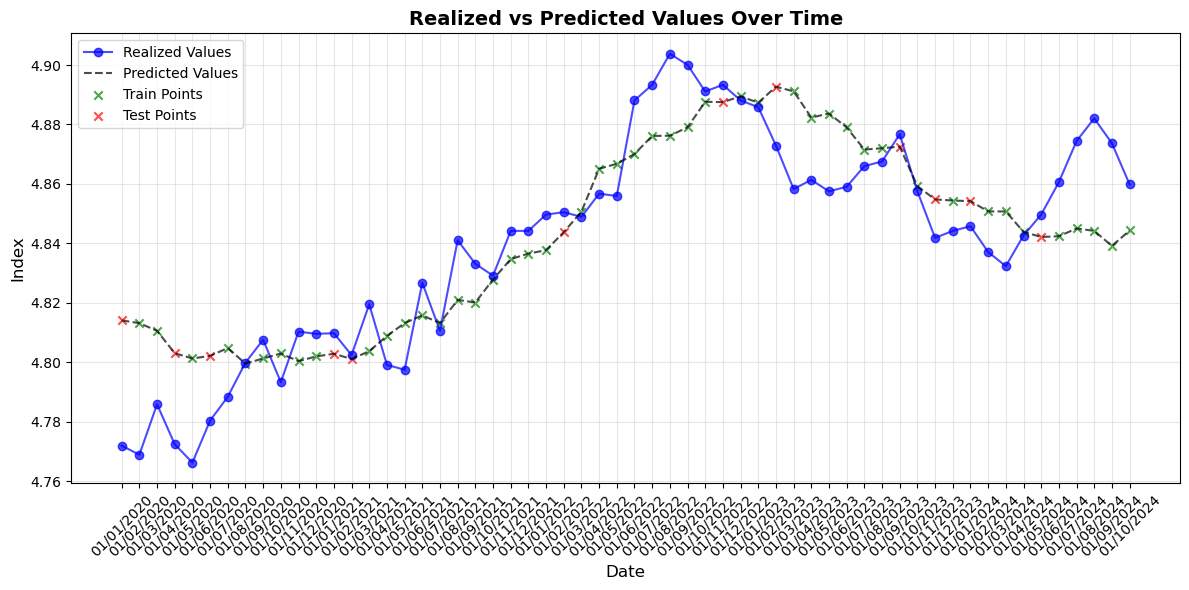

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(combined_data["Date"], combined_data["Actual"], label="Realized Values", color='blue', linestyle='-', marker='o', alpha=0.7)
plt.plot(combined_data["Date"], combined_data["Predicted"], label="Predicted Values", color='black', linestyle='--', alpha=0.7)
plt.scatter(combined_data.loc[combined_data["Dataset"] == "Train", "Date"],
            combined_data.loc[combined_data["Dataset"] == "Train", "Predicted"],
            color='green', label="Train Points", marker='x', alpha=0.7)
plt.scatter(combined_data.loc[combined_data["Dataset"] == "Test", "Date"],
            combined_data.loc[combined_data["Dataset"] == "Test", "Predicted"],
            color='red', label="Test Points", marker='x', alpha=0.7)

plt.title("Realized vs Predicted Values Over Time", fontsize=14, weight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Index", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()